In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import rearrange
import plotly.graph_objects as go
from collections import Counter, defaultdict

In [263]:
def funGauss(dist, t, r):
    return np.exp(-np.power(dist * t * r, 2))

def derivGauss(dist, t, r):
    return (2 - 4 * np.power(dist * t * r, 2)) * np.exp(-np.power(dist * t * r, 2))
    # return (1 - np.power(dist, 1)) * np.exp(-np.power(dist * t * r, 2))
    # return (2 * np.power(t * r, 2) - 4 * np.power(t * r, 4) * np.power(dist, 2)) * np.exp(-np.power(dist * t * r, 2))

class SOM:
    
    def __init__(self, M, N, dataSize, initWeights='uniform'):
        self.M = M
        self.N = N
        if initWeights == 'uniform':
            self.weights = np.random.uniform(0, 1, (N, M, dataSize))
        elif initWeights == 'evenly':
            self.weights = np.stack((np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, M))), axis=-1)
        self.map = rearrange(np.meshgrid(np.arange(M), np.arange(N)), "mapDim m n -> m n mapDim")

        
    def find_nearest(self, x):
        dist = np.sum(np.power((self.weights - x), 2), axis=2)
        return np.array(np.unravel_index(np.argmin(dist), dist.shape))
    
    def train(self, X, epoch, width, learningRate, neighborFun=funGauss):
                       
        for e in tqdm(range(epoch)):
            t = e
            r = width
            for row in X:
                coords = self.find_nearest(row)    # (x, y)
                coords = np.array([coords[1], coords[0]])
                dist = np.sqrt(np.sum(np.power(self.map - coords.reshape(1, 1, -1), 2), axis=2))
                self.weights += rearrange(neighborFun(dist, t, r), "N M -> N M 1") * learningRate * np.exp(-e/epoch) * (row - self.weights) 


def plotResults(somNet, data, type, title, interactive=False):

    flat_weights = rearrange(somNet.weights, "w h d -> (w h) d")
    if type == 2:
        plt.scatter(data['x'], data['y'], c=data['c'], cmap='rainbow')
        plt.scatter(flat_weights[:, 0], flat_weights[:, 1], marker='x', s=150, c='black')
        plt.title(title)
        plt.show()
    elif type == 3:
        if interactive:
            fig = go.Figure(data=[go.Scatter3d(
                x=cube['x'], y=cube['y'], z=cube['z'],
                mode='markers',
                marker=dict(
                    size=4,
                    color=cube['c'],
                    colorscale='viridis',
                    opacity=0.8
                )
            )])
            fig.add_trace(go.Scatter3d(
                x=flat_weights[:, 0], y=flat_weights[:, 1], z=flat_weights[:, 2],
                mode='markers',
                marker=dict(
                    size=5,
                    color='black',
                    opacity=1,
                    symbol='x'
                )
            ))
            fig.update_layout(
                title=title,
                width=800, height=800, margin=dict(l=0, r=0, b=0, t=0),
                scene=dict(
                    xaxis_title='X axis',
                    yaxis_title='Y axis',
                    zaxis_title='Z axis'
                )
            )
            fig.show()
        else:
            fig = plt.figure(figsize = (10, 10))
            ax = plt.axes(projection ="3d")
            ax.scatter3D(data['x'], data['y'], data['z'], c=data['c'], cmap='viridis')
            ax.scatter3D(flat_weights[:, 0], flat_weights[:, 1], flat_weights[:, 2], marker='x', s=150, c='black')
            ax.set_title(title)
            
    
    
def plotClusters(somNet, data, title):

    flat_weights = rearrange(somNet.weights, "w h d -> (w h) d")
    data_arr = np.array(data.iloc[:, :-1])
    closest_nodes = [tuple(somNet.find_nearest(row)) for row in data_arr]
    unique_nodes = list(set(closest_nodes))
    classes = [unique_nodes.index(node) for node in closest_nodes]
    cmap = 'Dark2'
    plt.figure(figsize=(10, 10))
    plt.scatter(data['x'], data['y'], c=data['c'], cmap=cmap, s=80, marker='s')
    plt.scatter(data['x'], data['y'], c=mapValues(list(data['c']), classes), cmap=cmap, s=20)
    plt.scatter(flat_weights[:, 0], flat_weights[:, 1], marker='x', s=150, c='black')
    plt.title(title)
    return plt


def mapValues(real_values, predicted_values):
    
    mapping = defaultdict(list)
    for real, predicted in zip(real_values, predicted_values):
        mapping[predicted].append(real)
    predicted_to_real_mapping = {key: Counter(values).most_common(1)[0][0] for key, values in mapping.items()}
    return [predicted_to_real_mapping[pred] for pred in predicted_values]


In [95]:
# data
hexa = pd.read_csv('KOH\\hexagon.csv')
hexa_arr = np.array(hexa.iloc[:, :-1])

cube = pd.read_csv('KOH\\cube.csv')
cube_arr = np.array(cube.iloc[:, :-1])

## Hexagon

100%|██████████| 10/10 [00:00<00:00, 17.24it/s]


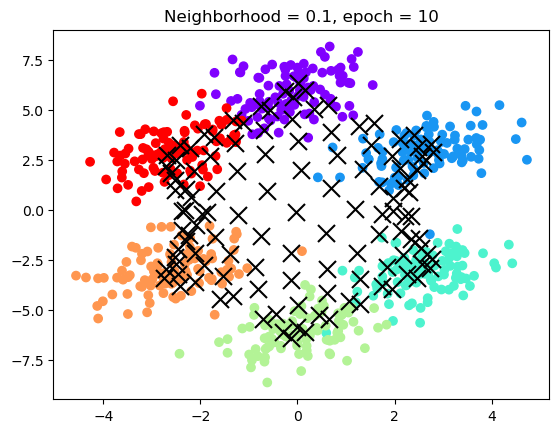

100%|██████████| 10/10 [00:00<00:00, 21.10it/s]


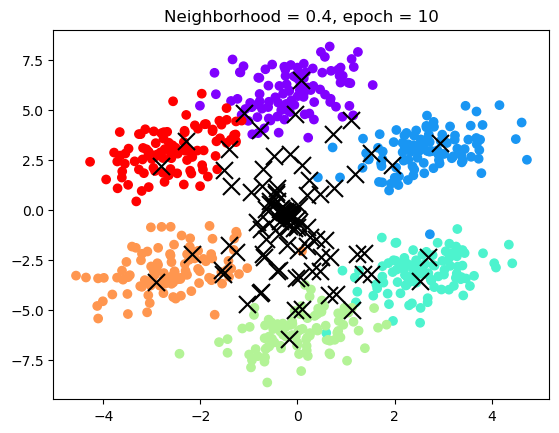

100%|██████████| 10/10 [00:00<00:00, 22.70it/s]


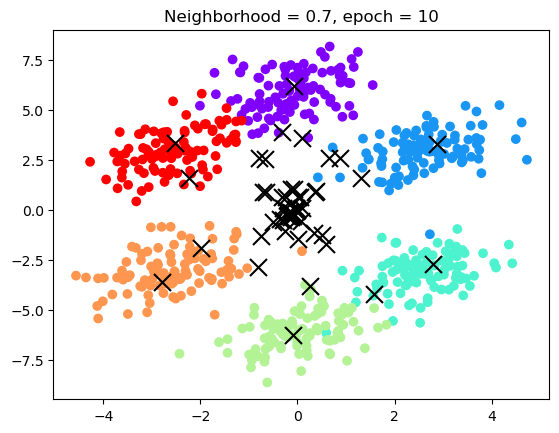

100%|██████████| 10/10 [00:00<00:00, 22.39it/s]


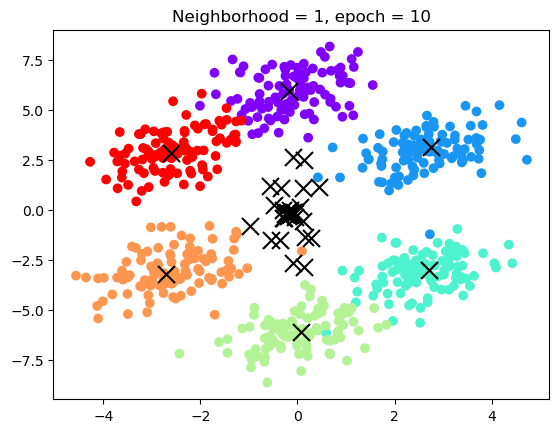

In [97]:
dim = int(np.sqrt(5*np.sqrt(hexa_arr.shape[0])))
test_neig = [0.1, 0.4, 0.7, 1]
for i in range(len(test_neig)):
    som_hex = SOM(dim, dim, 2)
    som_hex.train(X=hexa_arr, epoch=10, width=test_neig[i], learningRate=0.01)
    plotResults(som_hex, hexa, 2, f"Neighborhood = {test_neig[i]}, epoch = {10}")

100%|██████████| 100/100 [00:04<00:00, 21.04it/s]


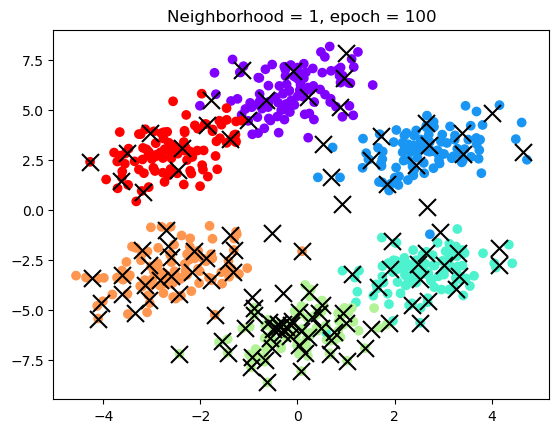

In [42]:
dim = int(np.sqrt(5*np.sqrt(hexa_arr.shape[0])))
som_hex = SOM(dim, dim, 2)
som_hex.train(X=hexa_arr, epoch=100, width=1, learningRate=0.99)
plotResults(som_hex, hexa, 2, f"Neighborhood = {1}, epoch = {100}")

100%|██████████| 10/10 [00:00<00:00, 21.17it/s]


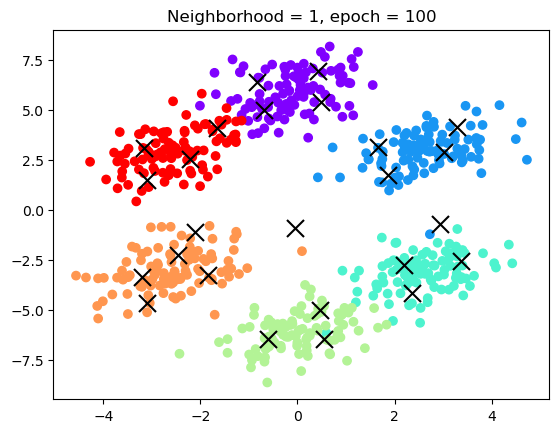

In [231]:
som_hex = SOM(5, 5, 2)
som_hex.train(X=hexa_arr, epoch=10, width=0.5, learningRate=0.1)
plotResults(som_hex, hexa, 2, f"Neighborhood = {1}, epoch = {100}")

100%|██████████| 10/10 [00:00<00:00, 18.10it/s]


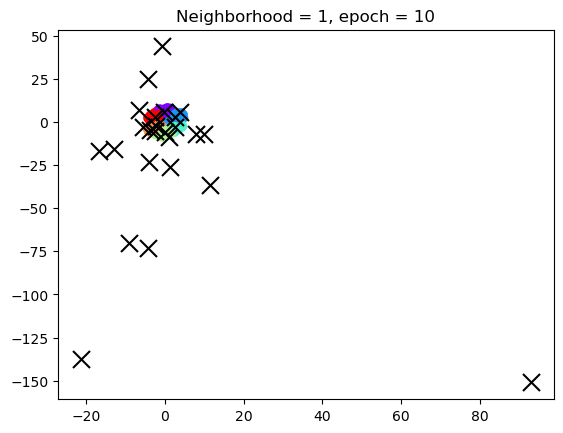

In [237]:
som_hex = SOM(5, 5, 2)
som_hex.train(X=hexa_arr, epoch=10, width=1, learningRate=0.02, neighborFun=derivGauss)
plotResults(som_hex, hexa, 2, f"Neighborhood = {1}, epoch = {10}")

100%|██████████| 10/10 [00:00<00:00, 20.49it/s]


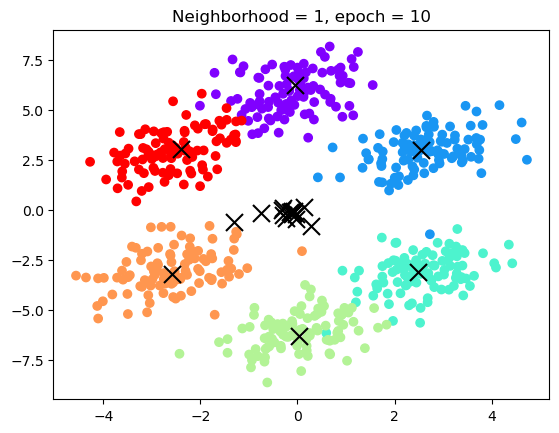

In [236]:
som_hex = SOM(5, 5, 2)
som_hex.train(X=hexa_arr, epoch=10, width=1, learningRate=0.003, neighborFun=derivGauss)
plotResults(som_hex, hexa, 2, f"Neighborhood = {1}, epoch = {10}")

100%|██████████| 10/10 [00:00<00:00, 21.36it/s]


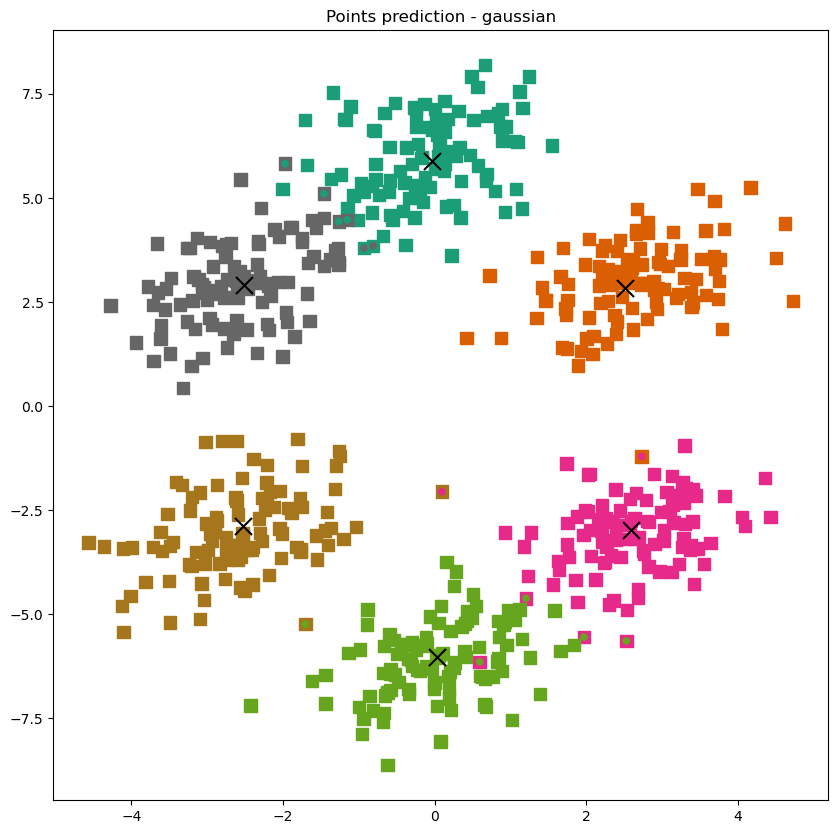

In [243]:
som_hex = SOM(3, 2, 2)
som_hex.train(X=hexa_arr, epoch=10, width=0.5, learningRate=0.01)
plotClusters(som_hex, hexa, "Points prediction - gaussian")

100%|██████████| 10/10 [00:00<00:00, 19.34it/s]


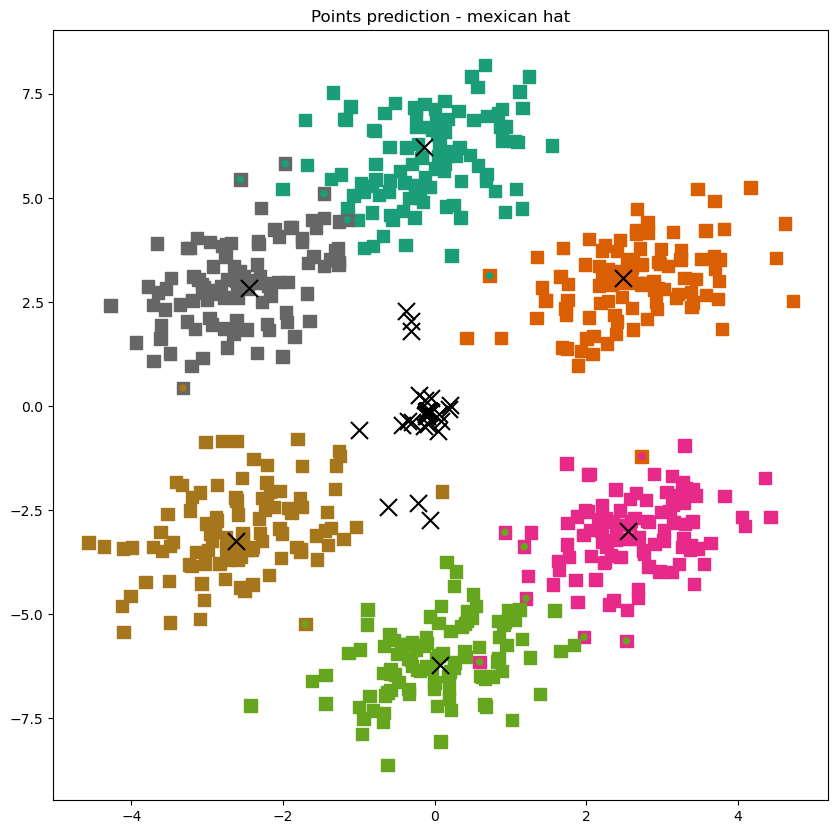

In [244]:
som_hex = SOM(10, 10, 2)
som_hex.train(X=hexa_arr, epoch=10, width=1, learningRate=0.003, neighborFun=derivGauss)
plotClusters(som_hex, hexa, "Points prediction - mexican hat")

## Cube

In [261]:
dim = int(np.sqrt(5*np.sqrt(cube_arr.shape[0])))
som_cube = SOM(dim, dim, 3)
som_cube.train(X=cube_arr, epoch=10, width=1, learningRate=0.1)
plotResults(som_cube, cube, 3, f"Neighborhood = {1}, epoch = {10}", True)

100%|██████████| 10/10 [00:01<00:00,  8.29it/s]


100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


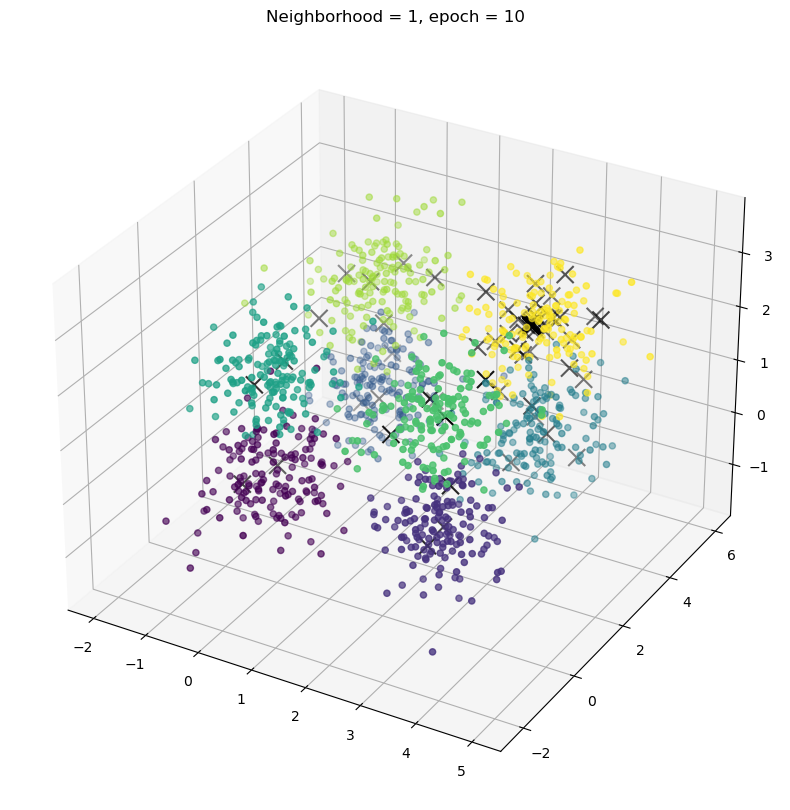

In [264]:
dim = int(np.sqrt(5*np.sqrt(cube_arr.shape[0])))
som_cube = SOM(dim, dim, 3)
som_cube.train(X=cube_arr, epoch=10, width=1, learningRate=0.1)
plotResults(som_cube, cube, 3, f"Neighborhood = {1}, epoch = {10}")

In [300]:
som_cube = SOM(4, 2, 3)
som_cube.train(X=cube_arr, epoch=40, width=0.3, learningRate=0.1)
plotResults(som_cube, cube, 3, f"Neighborhood = {1}, epoch = {10}", True)

100%|██████████| 40/40 [00:03<00:00, 12.96it/s]


In [282]:
dim = int(np.sqrt(5*np.sqrt(cube_arr.shape[0])))
som_cube = SOM(dim, dim, 3)
som_cube.train(X=cube_arr, epoch=30, width=1, learningRate=0.001, neighborFun=derivGauss)
plotResults(som_cube, cube, 3, f"", True)

100%|██████████| 30/30 [00:03<00:00,  7.64it/s]


In [283]:
dim = int(np.sqrt(5*np.sqrt(cube_arr.shape[0])))
som_cube = SOM(dim, dim, 3)
som_cube.train(X=cube_arr, epoch=30, width=1, learningRate=0.0015, neighborFun=derivGauss)
plotResults(som_cube, cube, 3, f"", True)

100%|██████████| 30/30 [00:03<00:00,  7.68it/s]


In [293]:
dim = int(np.sqrt(5*np.sqrt(cube_arr.shape[0])))
som_cube = SOM(dim, dim, 3)
som_cube.train(X=cube_arr, epoch=170, width=0.5, learningRate=0.0005, neighborFun=derivGauss)
plotResults(som_cube, cube, 3, f"", True)

100%|██████████| 170/170 [00:23<00:00,  7.31it/s]


In [297]:
dim = int(np.sqrt(5*np.sqrt(cube_arr.shape[0])))
som_cube = SOM(dim, dim, 3)
som_cube.train(X=cube_arr, epoch=50, width=0.3, learningRate=0.0001, neighborFun=derivGauss)
plotResults(som_cube, cube, 3, f"", True)

100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


In [312]:
som_cube = SOM(4, 2, 3)
som_cube.train(X=cube_arr, epoch=200, width=0.5, learningRate=0.0009, neighborFun=derivGauss)
plotResults(som_cube, cube, 3, f"", True)

100%|██████████| 200/200 [00:18<00:00, 10.95it/s]
